In [1]:
import os
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy.types import Integer, String, Float, DateTime
import seaborn as sns
from prophet import Prophet

# Configurações de visualização
%matplotlib inline
sns.set(style="whitegrid")

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
service_account_path = 'tfm-sa.json'
credentials = service_account.Credentials.from_service_account_file(service_account_path)
project_id = 'perseverance-332400'
dataset_id = 'TFM'
table_id = 'ds_market'
full_table_id = f'{project_id}.{dataset_id}.{table_id}'
client = bigquery.Client(project=project_id, credentials=credentials)

In [5]:
sample_query = f"""
SELECT *
FROM `{full_table_id}`
WHERE EXTRACT(YEAR FROM date) = 2015;
"""

def executar_consulta(sql, client):
    query_job = client.query(sql)
    return query_job.to_dataframe()

df = executar_consulta(sample_query, client)

In [7]:
print(df.head())

                       date  forecast_sales   store               item  \
0 2015-12-01 00:00:00+00:00       26.836978  Harlem  SUPERMARKET_3_252   
1 2015-12-02 00:00:00+00:00       29.422756  Harlem  SUPERMARKET_3_252   
2 2015-12-03 00:00:00+00:00       37.989811  Harlem  SUPERMARKET_3_252   
3 2015-12-04 00:00:00+00:00       48.975745  Harlem  SUPERMARKET_3_252   
4 2015-12-05 00:00:00+00:00       53.474063  Harlem  SUPERMARKET_3_252   

   actual_sales       rmse        mae          mape      order  
0            45  14.390572  10.527013  1.575665e+07  (4, 1, 3)  
1            21  14.390572  10.527013  1.575665e+07  (4, 1, 3)  
2            29  14.390572  10.527013  1.575665e+07  (4, 1, 3)  
3            46  14.390572  10.527013  1.575665e+07  (4, 1, 3)  
4            67  14.390572  10.527013  1.575665e+07  (4, 1, 3)  


In [4]:
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

In [5]:
product_id = 'ACCESORIES_1_238'
store_id = 'Harlem'
filtered_df = df[(df['item'] == product_id) & (df['store'] == store_id)]

In [6]:
filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.tz_localize(None)
filtered_df.set_index('date', inplace=True)
agg_data = filtered_df.resample('W').agg({'sales': 'sum'}).reset_index()
agg_data.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Tratar valores ausentes
agg_data['y'] = agg_data['y'].fillna(0)

C:\Users\rpiaz\AppData\Local\Temp\ipykernel_14204\4127124285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.tz_localize(None)


In [7]:
natal_events = pd.DataFrame({
    'holiday': ['Christmas'] * 6,
    'ds': pd.to_datetime(['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']),
    'lower_window': [-2] * 6,
    'upper_window': [1] * 6
})

ramadan_events = pd.DataFrame({
    'holiday': ['Ramadan'] * 6,
    'ds': pd.to_datetime(['2011-08-01', '2012-07-20', '2013-07-09', '2014-06-28', '2015-06-18', '2016-06-06']),
    'lower_window': [0] * 6,
    'upper_window': [30] * 6
})

events_df = pd.concat([natal_events, ramadan_events])
events_df = events_df[['ds', 'holiday', 'lower_window', 'upper_window']].drop_duplicates()

In [8]:
model = Prophet(holidays=events_df, yearly_seasonality=True, weekly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(agg_data)

11:28:41 - cmdstanpy - INFO - Chain [1] start processing
11:28:41 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = model.make_future_dataframe(periods=28, freq='D')  # Previsão diária para 28 dias
forecast = model.predict(future)

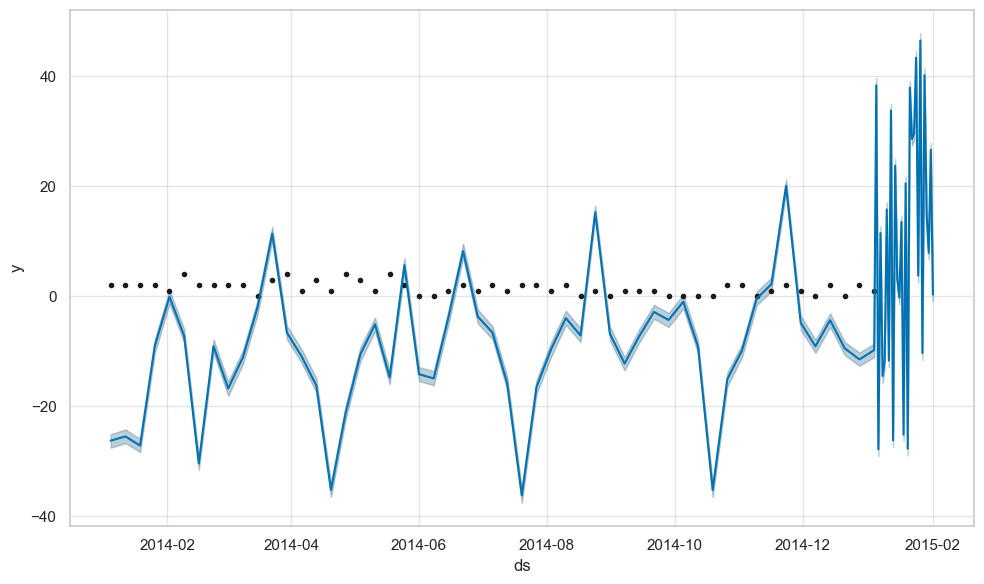

In [10]:
fig = model.plot(forecast)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.show()

In [11]:
forecast.to_csv('previsoes_vendas_28_dias.csv', index=False)

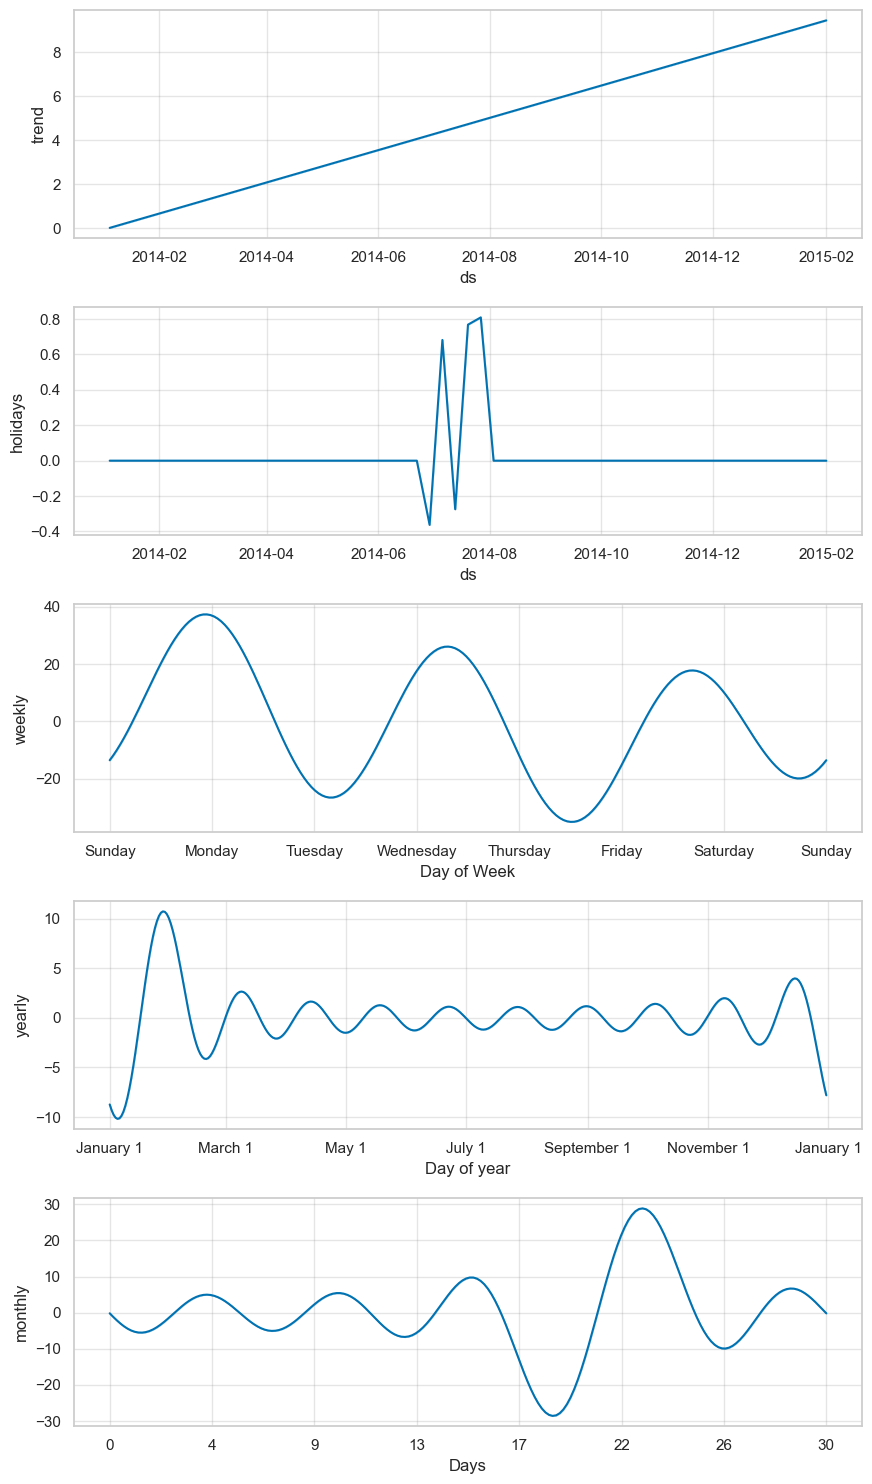

In [12]:
fig2 = model.plot_components(forecast)